# Natural Language Processing with Disaster Tweets

## Problem Statement and Justification

Twitter has become an essential communication platform, especially during emergencies. The widespread use of smartphones enables people to report emergencies in real-time, providing valuable information to disaster relief organizations, news agencies, and governmental bodies. However, distinguishing between genuine emergency tweets and unrelated messages poses a significant challenge.

Organizations that rely on Twitter for real-time disaster monitoring need an automated way to filter relevant tweets accurately. A machine learning model capable of distinguishing real disaster-related tweets from unrelated ones would enhance response times and resource allocation, ensuring efficient emergency management.

## Assumptions and Scope

- The dataset used for training the model consists of labeled tweets, identifying whether they describe a real disaster or not.

- Tweets may include textual indicators of disasters, such as figurative language that might lead to misclassification.

- The model assumes that tweets are written in English and that linguistic patterns can be used to determine their relevance.

- The model focuses on text-based features and does not incorporate external data sources (e.g., images, geolocation).

## Hypothesis (NLP Related):
- Tweets about real disasters have distinct linguistic patterns, including keywords, urgency markers, and direct mentions of locations or events.

- Sentiment analysis and keyword extraction can help differentiate real disaster tweets from metaphorical or unrelated statements.

- NLP techniques such as TF-IDF and word embeddings can effectively classify tweets into relevant and non-relevant categories.

## Data Description

The dataset consists of tweets labeled as either related to a disaster (1) or not (0). It contains the following columns:

   - id: A unique identifier for each tweet.

   - keyword: A keyword extracted from the tweet (may be blank).

   - location: The location from which the tweet was sent (may be blank).

   - text: The actual content of the tweet, which serves as the main feature for NLP processing.

   - target: Present only in the training data, with values:

     - 1: The tweet is about a real disaster.

     - 0: The tweet is not related to a disaster.

In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import urllib.parse
import nltk
from nltk.tokenize import RegexpTokenizer  # Changed from word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_download
from tqdm import tqdm
from textblob import TextBlob 

In [2]:
# loading the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Exploratory Data Analysis

In [3]:
#shape
train_shape=train_df.shape
print(f"The number of rows in the train dataset:",train_shape[0])
print(f"The number of columns in the train dataset:",train_shape[1])

print("-----------------------------------------------------------------")

test_shape= test_df.shape
print(f"The number of rows in the test dataset:",test_shape[0])
print(f"The number of columns in the test dataset:",test_shape[1])

The number of rows in the train dataset: 7613
The number of columns in the train dataset: 5
-----------------------------------------------------------------
The number of rows in the test dataset: 3263
The number of columns in the test dataset: 4


In [4]:
# info on the train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Insights:**
- Based on the above, we can tell we have no null values in the text column and target column.(Which are the main columns of interest).



In [5]:
train_df.sample(3)

id       keyword                     location  \
2520  3621    desolation           Monterrey, MÌ©xico   
6733  9650  thunderstorm  Lethbridge, Alberta, Canada   
5420  7736     panicking                          NaN   

                                                   text  target  
2520  Fear and panic in the air I want to be free fr...       0  
6733  [HIGH PRIORITY] SEVERE THUNDERSTORM WATCH ENDE...       1  
5420                        Ay I am fully panicking lol       0

In [6]:
# checking for duplicate rows
train_df.duplicated().sum()

np.int64(0)

- The dataset does not contain any duplicate rows.

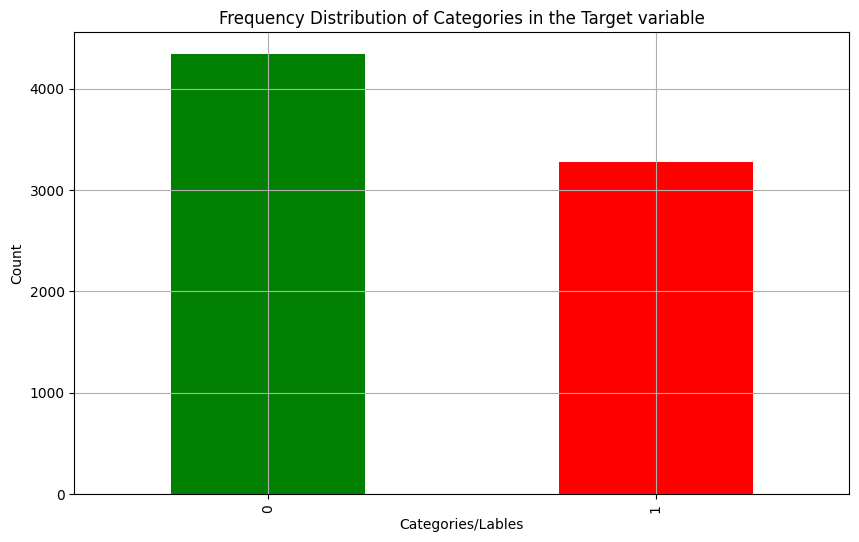

In [7]:
# Visualising the target variable ------> 1: Real disaster , 0: Not related to disaster
disater_cat = train_df['target'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g','r']
disater_cat.plot(kind='bar',color=my_colors)
plt.grid()
plt.xlabel('Categories/Lables')
plt.ylabel("Count")
plt.title("Frequency Distribution of Categories in the Target variable")
plt.show()

In [8]:
disater_cat

target
0    4342
1    3271
Name: count, dtype: int64

- The dataset is not imbalanced, since the target: 1 is more than 6%.

### Word Cloud

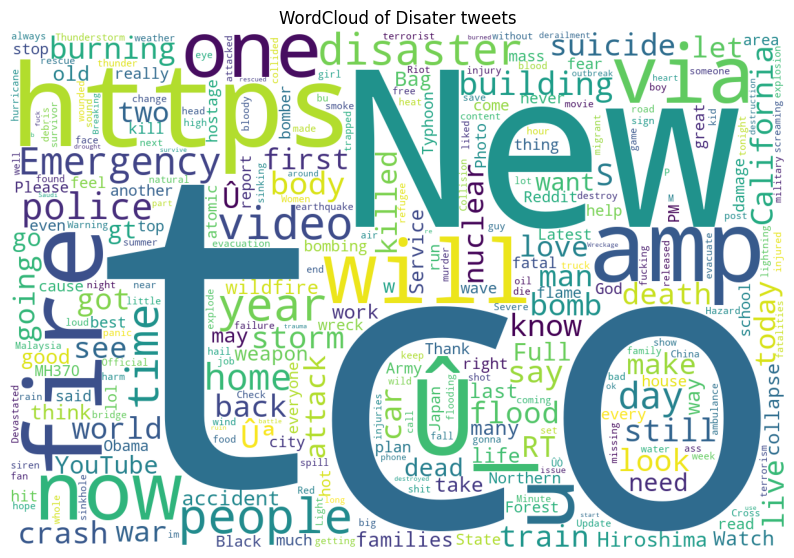

In [9]:
from wordcloud import WordCloud
plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=300, width=1200, height = 800, background_color="white",collocations=False).generate(" ".join(train_df['text']))

plt.grid(None)
plt.title('WordCloud of Disater tweets')
plt.axis('off')
plt.imshow(wordcloud)

## Text processing

Usually text corpora and other textual data in their native raw format are not well formatted and standardized, and of course, we should expect this—after all, text data is highly unstructured! Text processing, or to be more specific, pre-processing, involves using a variety of techniques to convert raw text into welldefined sequences of linguistic components that have standard structure and notation

Preprocess the data by:
<ul>
    <li>Convert all the text to lower case. Replcing special characters with space</li>
    <li>Replcing multiple spaces with a single space</li>
    <li>Convert all the text to lower case</li>
    <li>Tokenization</li>
    <li>Stemming</li>
    <li>Lemmatization</li>
    <li>Remove all stop words</li>    
</ul>
- 

In [11]:
import unicodedata

In [12]:
# Initialize NLTK
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# 1. Enhanced Twitter artifact patterns
TWITTER_ARTIFACTS = [
    r'Û[_ª©óï÷¾°¢£¬]',  # Common encoding artifacts
    r'Û',              # Partial artifacts
    r'Û[_]?',           # Catches "Û" and "Û_"
    r'[\x80-\xff]',     # High-byte characters
    r'\b[uû]\b'         # Isolated "u"/"û" from artifacts
]

# 2. Core terms and HTML mappings
CORE_TERMS = {
    # Disaster terms
    'earthquake', 'tsunami', 'fire', 'flood', 'hurricane', 'tornado',
    'wildfire', 'cyclone', 'avalanche', 'blizzard', 'emergency',
    'warning', 'alert', 'evacuate', 'evacuation', 'shelter', 'rescue',
    
    # Location markers
    'near', 'in', 'at', 'area', 'region', 'coastal', 'district', 
    'zone', 'city', 'town', 'village', 'county', 'state', 'province'
}

HTML_ENTITIES = {
    '&amp;': 'and',
    '&lt;': '<',
    '&gt;': '>',
    '&quot;': '"',
    '&apos;': "'"
}

# 3. Tokenizer with enhanced pattern
tokenizer = RegexpTokenizer(r"(?:\w+[-']\w+|\w+)")

def clean_text_advanced(text):
    """Multi-stage text cleaning with Unicode normalization"""
    if not isinstance(text, str):
        return ""
    
    # Stage 1: Unicode normalization
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Stage 2: Remove Twitter artifacts
    for pattern in TWITTER_ARTIFACTS:
        text = re.sub(pattern, ' ', text)
    
    # Stage 3: Clean residual artifacts
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def correct_spelling(text):
    """Spelling correction with disaster term protection"""
    try:
        blob = TextBlob(text)
        corrected = []
        for word in blob.words:
            lower_word = word.lower()
            if lower_word in CORE_TERMS or word.istitle():
                corrected.append(str(word))
            else:
                corrected.append(str(word.correct()))
        return ' '.join(corrected)
    except:
        return text

def preprocess_text(text):
    original = text
    
    # 1. Advanced cleaning
    text = clean_text_advanced(text)
    
    # 2. Replace HTML entities
    for entity, replacement in HTML_ENTITIES.items():
        text = text.replace(entity, replacement)
    
    # 3. Remove URLs/mentions
    text = re.sub(r'https?://\S+|www\.\S+|@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)  # Keep hashtag content
    
    # 4. Spelling correction
    text = correct_spelling(text)
    
    # 5. Tokenize and filter
    tokens = tokenizer.tokenize(text.lower())
    filtered = [word for word in tokens 
               if (word in CORE_TERMS) or (word not in stop_words and len(word) > 1)]
    
    # Final cleanup
    processed_text = ' '.join(filtered)
    processed_text = re.sub(r'\b[uû]\b', '', processed_text)  # Final pass
    
    print("\nTEXT PROCESSING")
    print(f"Before:\n{original}")
    print(f"After:\n{processed_text}")
    print("-"*60)
    
    return processed_text

def process_dataframe(df, name):
    print(f"\n{'='*30} PROCESSING {name.upper()} SET {'='*30}")
    tqdm.pandas(desc=f"Processing {name} texts")
    df['processed_text'] = df['text'].progress_apply(preprocess_text)
    return df

# Setup and execution
print("Running first-time setup...")
nltk.download('stopwords')
nltk.download('punkt')
try:
    from textblob import download_corpora
    download_corpora()
except:
    pass

train_df = process_dataframe(train_df, "train")
test_df = process_dataframe(test_df, "test")

[nltk_data] Downloading package stopwords to C:\Users\Pavilion Plus
[nltk_data]     14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Pavilion Plus
[nltk_data]     14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Pavilion Plus
[nltk_data]     14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Pavilion Plus
[nltk_data]     14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Running first-time setup...

============================== PROCESSING TRAIN SET ==============================


Processing train texts:   3%|▎         | 249/7613 [00:00<00:05, 1322.12it/s]


TEXT PROCESSING
Before:
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After:
deeds reason earthquake may allah forgive us
------------------------------------------------------------

TEXT PROCESSING
Before:
Forest fire near La Ronge Sask. Canada
After:
forest fire near la ronge sask canada
------------------------------------------------------------

TEXT PROCESSING
Before:
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
After:
residents asked shelter in place notified officers evacuation shelter in place orders expected
------------------------------------------------------------

TEXT PROCESSING
Before:
13,000 people receive #wildfires evacuation orders in California 
After:
13 000 people receive wildfires evacuation orders in california
------------------------------------------------------------

TEXT PROCESSING
Before:
Just got sent this photo from Ruby #Alaska as smoke 

Processing train texts:   8%|▊         | 599/7613 [00:00<00:04, 1606.01it/s]


TEXT PROCESSING
Before:
World Annihilation vs Self Transformation http://t.co/pyehwodWun Aliens Attack to Exterminate Humans http://t.co/pB2N77nSKz
After:
world annihilation vs self transformation aliens attack exterminate humans
------------------------------------------------------------

TEXT PROCESSING
Before:
:StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via @YouTube
After:
starmade stardate planetary annihilation via
------------------------------------------------------------

TEXT PROCESSING
Before:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/m8MvDSPJp7 via @Change
After:
national park services tonto national forest stop annihilation salt river wild horse via
------------------------------------------------------------

TEXT PROCESSING
Before:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/sW1sBua3mN via @Chan

Processing train texts:  12%|█▏        | 918/7613 [00:00<00:04, 1562.87it/s]


TEXT PROCESSING
Before:
Government Experts Concerned About Possible Bioterrorism Using GM Organisms: Scientists are concerned that the... http://t.co/SuMe5prO0F
After:
government experts concerned possible bioterrorism using gm organisms scientists concerned
------------------------------------------------------------

TEXT PROCESSING
Before:
Does This Prepare Us? HHS Selects 9 Regional Special #Pathogen Treatment Centers #Bioterrorism #Infectious #Ebola http://t.co/Qmo1TxxDkj
After:
prepare us hhs selects regional special pathogen treatment centers bioterrorism infectious ebola
------------------------------------------------------------

TEXT PROCESSING
Before:
@StationCDRKelly Any Support Sys 4 @USAgov AUTH taken Hostage by BLK US clergyforced 2 exist younger&amp;grossly disfigured by BIOTERRORISM?@AP
After:
support sys auth taken hostage blk us clergyforced exist youngerandgrossly disfigured bioterrorism
------------------------------------------------------------

TEXT PROCESSING

Processing train texts:  16%|█▌        | 1229/7613 [00:00<00:04, 1534.76it/s]


TEXT PROCESSING
Before:
@HopefulBatgirl went down I was beaten and blown up. Then next thing I know Ra Al Ghul brought me back to life and I escaped and for a---
After:
went beaten blown next thing know ra al ghul brought back life escaped
------------------------------------------------------------

TEXT PROCESSING
Before:
@thebriankrause leos ass just got metaphorically blown up again #PiperWearsThePants #charmed
After:
leos ass got metaphorically blown piperwearsthepants charmed
------------------------------------------------------------

TEXT PROCESSING
Before:
@anarchic_teapot @BoironUSA @zeno001 Glononium 6C also helps with being blown up while bashing a bottle of nitroglycerin against a book.
After:
glononium 6c also helps blown bashing bottle nitroglycerin book
------------------------------------------------------------

TEXT PROCESSING
Before:
New Ladies Shoulder Tote Handbag Women Cross Body Bag Faux Leather Fashion Purse - Full reÛ_ http://t.co/y87Gi3BRlV http://t.co/1zb

Processing train texts:  20%|██        | 1557/7613 [00:01<00:03, 1592.20it/s]


TEXT PROCESSING
Before:
Now on http://t.co/3sTH9lrBUn: PHOTOS: Flames rage through Manchester buildings in 3-alarm fire http://t.co/jQxM4gcQZ3 #NH1News
After:
photos flames rage manchester buildings in 3-alarm fire nh1news
------------------------------------------------------------

TEXT PROCESSING
Before:
@BigSim50 nah Philly pundits are half the cause. They set buildings on fire to report on buildings being on fire.
After:
nah philly pundits half cause set buildings fire report buildings fire
------------------------------------------------------------

TEXT PROCESSING
Before:
MaFireEMS: RT WMUR9: Two buildings involved in fire on 2nd Street in #Manchester. WMUR9  http://t.co/QUFwXRJIql via KCarosaWMUR
After:
mafireems rt wmur9 two buildings involved in fire 2nd street in manchester wmur9 via kcarosawmur
------------------------------------------------------------

TEXT PROCESSING
Before:
Now on WSLS: fire burns multiple buildings in #Montgomery Co tips to make childcare less expen

Processing train texts:  26%|██▌       | 1942/7613 [00:01<00:03, 1768.29it/s]


TEXT PROCESSING
Before:
627% but if they had lower striked than 16 I would have gone even further OTM. This could really fall off a cliff.
After:
627 lower striked 16 would gone even otm could really fall cliff
------------------------------------------------------------

TEXT PROCESSING
Before:
That sounds like a really bad idea I like Yoenis but I feel like his production could fall off a huge cliff.
After:
sounds like really bad idea like yoenis feel like production could fall huge cliff
------------------------------------------------------------

TEXT PROCESSING
Before:
'I'm there!' Bride &amp; Groom on mountain cliff edge. Ha Ha just kidding. I WILL NOT EVER be there. Ha Ha - http://t.co/Io9ry1akON
After:
bride groom mountain cliff edge ha ha kidding ever ha ha
------------------------------------------------------------

TEXT PROCESSING
Before:
ESN :  Cilla Black died of stroke after fall in Spain: Sir Cliff revealed he was due to visit her in Spain nextÛ_ http://t.co/F7a66dIi

Processing train texts:  28%|██▊       | 2140/7613 [00:01<00:02, 1831.34it/s]


TEXT PROCESSING
Before:
@riverroaming 'And not too much danger please.'
After:
much danger please
------------------------------------------------------------

TEXT PROCESSING
Before:
@bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM 
https://t.co/moLL5vd8yD
After:
fettilootch slanglucci oppressions greatest danger coming soon album
------------------------------------------------------------

TEXT PROCESSING
Before:
.@Uber is looking to repair its recent bad rap with some #nonprofit partnerships: http://t.co/h1xch54Kd3
After:
looking repair recent bad rap nonprofit partnerships
------------------------------------------------------------

TEXT PROCESSING
Before:
I wish I could get Victoria's Secret on front. I'm good for it.
After:
wish could get victoria's secret front good
------------------------------------------------------------

TEXT PROCESSING
Before:
@TurnedonFetaboo @HSjb215 Check out this #rockin preview of @ClaytonBryant Danger 

Processing train texts:  36%|███▌      | 2744/7613 [00:01<00:02, 1854.39it/s]


TEXT PROCESSING
Before:
#BBSNews latest 4 #Palestine &amp; #Israel -  Six Palestinians Kidnapped in West Bank Hebron Home Demolished http://t.co/gne1fW0XHE
After:
bbsnews latest palestine israel six palestinians kidnapped in west bank hebron home demolished
------------------------------------------------------------

TEXT PROCESSING
Before:
@David5Fernandez @theblaze trump will get absolutely demolished in a general election.
After:
trump get absolutely demolished in general election
------------------------------------------------------------

TEXT PROCESSING
Before:
It was finally demolished in the spring of 2013 and the property has sat vacant since. The justÛ_: saddlebrooke... http://t.co/Vcjcykq8b8
After:
finally demolished in spring 2013 property sat vacant since justu_ saddlebrooke
------------------------------------------------------------

TEXT PROCESSING
Before:
@stallion150 @kbeastx they totally demolished genisys which was a beautiful film and almost 90% of the people a

Processing train texts:  42%|████▏     | 3166/7613 [00:01<00:02, 1975.09it/s]


TEXT PROCESSING
Before:
Is Stuart Broad the Prime Minister yet. Best thing in Sport I have seen for years that. The Aussies look devastated. Bless ??????
After:
stuart broad prime minister yet best thing in sport seen years aussies look devastated bless
------------------------------------------------------------

TEXT PROCESSING
Before:
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/XDt4VHFn7B
After:
obama declares disaster typhoon-devastated saipan obama signs disaster declaration northern marians
------------------------------------------------------------

TEXT PROCESSING
Before:
@WesleyLowery ?????? how are you going to survive this devastation?
After:
going survive devastation
------------------------------------------------------------

TEXT PROCESSING
Before:
I'm in utter shock and devastation you don't go to work to be left feeling how I do now. Life really is too short ??
After:
in utter shock dev

Processing train texts:  47%|████▋     | 3567/7613 [00:02<00:02, 1902.89it/s]


TEXT PROCESSING
Before:
Cool Tips from our friends at Counterstrike Security &amp; Sound.... http://t.co/z5Y4Xr14W6
After:
cool tips friends at counterstrike security sound
------------------------------------------------------------

TEXT PROCESSING
Before:
b/c it costs less to have sick people using emergency rooms?...grrrr.... http://t.co/vFbbcHwrFD
After:
costs less sick people using emergency rooms grrrr
------------------------------------------------------------

TEXT PROCESSING
Before:
ÛÏ@based_georgie: yo forreal we need to have like an emergency action plan incase donald trump becomes presidentÛ
Whipe that lil baby
After:
ui yo forreal need like emergency action plan incase donald trump becomes presidentu whipe lil baby
------------------------------------------------------------

TEXT PROCESSING
Before:
@RebeccaforReal accepts Wisconsin Emergency Response Plan on behalf of @GovWalker #nbc15 http://t.co/Pis0aiVRbR
After:
accepts wisconsin emergency response plan behalf nb

Processing train texts:  52%|█████▏    | 3967/7613 [00:02<00:01, 1940.77it/s]


TEXT PROCESSING
Before:
when things become terrible more than the great Ethiopian famine...
After:
things become terrible great ethiopian famine
------------------------------------------------------------

TEXT PROCESSING
Before:
@SavageNation Reminds me when the Peasants destroyed their food when Stalin's army came to 'redistribute the wealth'. It caused famine/death
After:
reminds peasants destroyed food stalin's army came redistribute wealth caused famine death
------------------------------------------------------------

TEXT PROCESSING
Before:
UPDATE 1-Russian 'food crematoria' provoke outrage amid crisis famine memories: * Russian society still recal... http://t.co/J2erZbMjQD
After:
update 1-russian food crematoria provoke outrage amid crisis famine memories russian society still recal
------------------------------------------------------------

TEXT PROCESSING
Before:
The Adventures of Mineness #9   The Famine Is Over http://t.co/spYmIQNeCj
After:
adventures mineness famine
-

Processing train texts:  55%|█████▍    | 4163/7613 [00:02<00:02, 1527.47it/s]


TEXT PROCESSING
Before:
Obama Keeps 27 Iraqi Christian Asylum Seekers nDetention While Flooding U.S. w/Unscreened Muslims: http://t.co/b4k0R4GgA8 via @DCClothesline
After:
obama keeps 27 iraqi christian asylum seekers ndetention flooding unscreened muslims via
------------------------------------------------------------

TEXT PROCESSING
Before:
So grateful for all the support flooding in from @NetkiCorp dinner guests! THANK YOU ALL! https://t.co/ELTne5v1Qn
After:
grateful support flooding in dinner guests thank
------------------------------------------------------------

TEXT PROCESSING
Before:
There some flash flooding in madison #valleywx
After:
flash flooding in madison valleywx
------------------------------------------------------------

TEXT PROCESSING
Before:
@themaine is it too soon to start flooding your comment section with 'come to brazil' comments? bc i will
After:
soon start flooding comment section come brazil comments bc
------------------------------------------------

Processing train texts:  57%|█████▋    | 4330/7613 [00:02<00:02, 1502.85it/s]


TEXT PROCESSING
Before:
@news4buffalo yes a lot more harm then good if there are guardrails up now why cant we go 50. Their will be a big problem when school starts
After:
yes lot harm good guardrails cant go 50 big problem school starts
------------------------------------------------------------

TEXT PROCESSING
Before:
@space_wolverine No harm no foul and somebody needed to say it.
After:
harm foul somebody needed say
------------------------------------------------------------

TEXT PROCESSING
Before:
@TasteMyCupCakee lmfaooo  hell nawh ?? yo ass thought ??
After:
lmfaooo hell nawh yo ass thought
------------------------------------------------------------

TEXT PROCESSING
Before:
self harm// I'm so angry please tag your scars on tumblr jesus christ i dont wanna get triggered
After:
self harm angry please tag scars tumblr jesus christ dont wanna get triggered
------------------------------------------------------------

TEXT PROCESSING
Before:
@RJG0789 idk....I feel like his movie

Processing train texts:  61%|██████▏   | 4671/7613 [00:02<00:01, 1570.59it/s]


TEXT PROCESSING
Before:
Cruz: Iran deal Û÷leaves 4 American hostages languishing in IranÛª  http://t.co/EXsQIJF4nY - #NoIranDeal  #TedCruz2016 http://t.co/y7sIPKB1kd
After:
cruz iran deal uleaves american hostages languishing in iranua noirandeal tedcruz2016
------------------------------------------------------------

TEXT PROCESSING
Before:
Nigerian Military Rescue 178 Hostages From Boko Haram - Florida Sentinel Bulletin: Florid... http://t.co/KcTiGYMahl #security #terrorism
After:
nigerian military rescue 178 hostages boko haram florida sentinel bulletin florid security terrorism
------------------------------------------------------------

TEXT PROCESSING
Before:
No #news of #hostages in #Libya

http://t.co/k9FBtcCU58

#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/XYj0rPsAI2
After:
news hostages in libya india terrorism africa ap ts nri news trs tdp bjp
------------------------------------------------------------

TEXT PROCESSING
Before:
One Year on fro

Processing train texts:  67%|██████▋   | 5072/7613 [00:03<00:01, 1772.49it/s]


TEXT PROCESSING
Before:
@VictoriaGittins what do you take me for I'm not a mass murderer! Just the one...
After:
take mass murderer one
------------------------------------------------------------

TEXT PROCESSING
Before:
Happy boy to mass murderer http://t.co/xPddWH5teM
After:
happy boy mass murderer
------------------------------------------------------------

TEXT PROCESSING
Before:
@NeanderRebel If you take the suit off him I wouldn't be surprised to hear this is the face that belonged to another democrat mass-murderer
After:
take suit surprised hear face belonged another democrat mass-murderer
------------------------------------------------------------

TEXT PROCESSING
Before:
Has gun law ever dissuaded a potential mass murderer?
After:
gun law ever dissuaded potential mass murderer
------------------------------------------------------------

TEXT PROCESSING
Before:
Another White mass murderer. Thank God I live in California.  https://t.co/4COg0OTiWn
After:
another white mass m

Processing train texts:  72%|███████▏  | 5501/7613 [00:03<00:01, 1723.16it/s]


TEXT PROCESSING
Before:
@DrAtomic420 where did you get that pic from where it shows that there is 2 trophies for Outbreak? Or did they photoshop it?
After:
get pic shows trophies outbreak photoshop
------------------------------------------------------------

TEXT PROCESSING
Before:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/mNsy1QR7bq
After:
families sue legionnaires 40 families affected fatal outbreak legionnaires disea
------------------------------------------------------------

TEXT PROCESSING
Before:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/kkdX8zMV4G
After:
families sue legionnaires 40 families affected fatal outbreak legionnaires disea
------------------------------------------------------------

TEXT PROCESSING
Before:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Le

Processing train texts:  77%|███████▋  | 5876/7613 [00:03<00:00, 1768.96it/s]


TEXT PROCESSING
Before:
#Turkish couple decided to feed 4000 #Syrian #refugees as part of their #wedding celebrations http://t.co/EHLq3ZSPTd http://t.co/DjX5eLbrv1
After:
turkish couple decided feed 4000 syrian refugees part wedding celebrations
------------------------------------------------------------

TEXT PROCESSING
Before:
@fadelurker @dalinthanelan &lt; right now.

Even after two years there were still refugees camped just south of Redcliffe village and Aidan &gt;
After:
right even two years still refugees camped south redcliffe village aidan
------------------------------------------------------------

TEXT PROCESSING
Before:
Newlyweds feed thousands of Syrian refugees instead of hosting a banquet wedding dinner http://t.co/EGcv7ybjae #Age #news
After:
newlyweds feed thousands syrian refugees instead hosting banquet wedding dinner age news
------------------------------------------------------------

TEXT PROCESSING
Before:
In Photos: The Young Refugees Forced to Flee Burundi

Processing train texts:  82%|████████▏ | 6228/7613 [00:03<00:00, 1612.41it/s]


TEXT PROCESSING
Before:
@justinbieber   I AM SCREAMING HELL YES AHHHH OMG http://t.co/y678XsNvJ6
After:
screaming hell yes ahhhh omg
------------------------------------------------------------

TEXT PROCESSING
Before:
like little boy you better sit your ass down stop screaming at my mother stop pulling your hair &amp; crying like a 3 year old &amp; grow tf up
After:
like little boy better sit ass stop screaming at mother stop pulling hair crying like year old grow tf
------------------------------------------------------------

TEXT PROCESSING
Before:
@ArianaGrande @justinbieber OMGGGG IM SCREAMING
After:
omgggg im screaming
------------------------------------------------------------

TEXT PROCESSING
Before:
@TromboneTristan OOOOOHSHIT OOOHSHIT SCREAMS hell I LOVE
After:
ooooohshit ooohshit screams hell love
------------------------------------------------------------

TEXT PROCESSING
Before:
@DaneMillar1 *screams 666*
After:
screams 666
---------------------------------------------

Processing train texts:  84%|████████▍ | 6392/7613 [00:03<00:00, 1272.56it/s]


TEXT PROCESSING
Before:
It's okay I welcome the rain. 
Gave you all the storm that you could weather.
After:
okay welcome rain gave storm could weather
------------------------------------------------------------

TEXT PROCESSING
Before:
Nike Golf Storm Fit Golf Jacket Black Medium http://t.co/jvAI5Vkmsy: #SportingGoods http://t.co/Nr8JjmpmoS
After:
nike golf storm fit golf jacket black medium sportinggoods
------------------------------------------------------------

TEXT PROCESSING
Before:
Every time I buy a bag for life I think I've got 3 days left to live.
After:
every time buy bag life think got days left live
------------------------------------------------------------

TEXT PROCESSING
Before:
What tropical storm? #guillermo by hawaiianpaddlesports http://t.co/LgPgAjgomY http://t.co/FKd1mBTB68
After:
tropical storm guillermo hawaiianpaddlesports
------------------------------------------------------------

TEXT PROCESSING
Before:
New item: Pillow Covers ANY SIZE Pillow Cover Gre

Processing train texts:  88%|████████▊ | 6724/7613 [00:04<00:00, 1446.56it/s]


TEXT PROCESSING
Before:
Alleged driver in #Kuwait attack 'joined Daesh just a day before the June 26 suicide bombing' he confesses in court http://t.co/Tmz6X1N2gQ
After:
alleged driver in kuwait attack joined daesh day june 26 suicide bombing confesses in court
------------------------------------------------------------

TEXT PROCESSING
Before:
@Haji_Hunter762 @MiddleEastEye maybe some muzzies will spontaneously combust! It's like Allah suicide bombing them as payback ????????
After:
maybe muzzies spontaneously combust like allah suicide bombing payback
------------------------------------------------------------

TEXT PROCESSING
Before:
The number of security officials killed by PKK in terror attacks since the Suruc suicide bombing has reached 22 https://t.co/OpJwuNUvG8
After:
number security officials killed pkk in terror attacks since suruc suicide bombing reached 22
------------------------------------------------------------

TEXT PROCESSING
Before:
'Suicide bombing at [location

Processing train texts:  90%|█████████ | 6878/7613 [00:04<00:00, 1354.35it/s]


TEXT PROCESSING
Before:
Railways caught unawares by MP tragedy; Accident spot never marked as Û÷vulnerableÛª http://t.co/UB1JZskmRc
After:
railways caught unawares mp tragedy accident spot never marked uvulnerableua
------------------------------------------------------------

TEXT PROCESSING
Before:
@TOIIndiaNews ofcourse 

Just 8 minute b4 tragedy another train had crossed this place 

N a flash flood caued washing of tracks..
After:
ofcourse minute b4 tragedy another train crossed place flash flood caued washing tracks
------------------------------------------------------------

TEXT PROCESSING
Before:
#ModiMinistry Rly tragedy in MP: Some live to recount horror http://t.co/s43wE7Oe2i
After:
modiministry rly tragedy in mp live recount horror
------------------------------------------------------------

TEXT PROCESSING
Before:
Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called ... http://t.co/vScPGMsJXY
After:
rly traged

Processing train texts:  94%|█████████▍| 7149/7613 [00:04<00:00, 1179.62it/s]


TEXT PROCESSING
Before:
love 106.1 The Twister @1061thetwister  and Maddie and Tae #OKTXDUO
After:
love 106 twister maddie tae oktxduo
------------------------------------------------------------

TEXT PROCESSING
Before:
Brain twister homefolks are opinionated over against proposal modernized canada: oMw
After:
brain twister homefolks opinionated proposal modernized canada omw
------------------------------------------------------------

TEXT PROCESSING
Before:
Crazy Mom Threw Teen Daughter a NUDE Twister Sex Party According To Her Friend59 more pics http://t.co/t94LNfwf34 http://t.co/roCyyEI2dM
After:
crazy mom threw teen daughter nude twister sex party according friend59 pics
------------------------------------------------------------

TEXT PROCESSING
Before:
The Sharper Image Viper 24' Hardside Twister (Black) http://t.co/FXk3zsj2PE
After:
sharper image viper 24 hardside twister black
------------------------------------------------------------

TEXT PROCESSING
Before:
Twister was

Processing train texts:  97%|█████████▋| 7389/7613 [00:04<00:00, 1077.46it/s]


TEXT PROCESSING
Before:
03/08/11: Police stop a 41-year-old in the Bronx citing 'casing a victim or location.' No weapon is found.
After:
03 08 11 police stop 41-year old in bronx citing casing victim location weapon found
------------------------------------------------------------

TEXT PROCESSING
Before:
Lol
Look how tough some people talk that live in some of the most gang infested cities in America
Your mouth isn't a weapon
You fucking wimp
After:
lol look tough people talk live in gang infested cities in america mouth weapon fucking wimp
------------------------------------------------------------

TEXT PROCESSING
Before:
I'm servicin in my section I'm lurkin I'm with my weapon
After:
servicin in section lurkin weapon
------------------------------------------------------------

TEXT PROCESSING
Before:
Iranian warship points weapon at American helicopter... http://t.co/cgFZk8Ha1R
After:
iranian warship points weapon at american helicopter
----------------------------------------

Processing train texts: 100%|██████████| 7613/7613 [00:04<00:00, 1532.28it/s]



TEXT PROCESSING
Before:
Richmond police officer wounded suspect killed http://t.co/m9d2ElImZI
After:
richmond police officer wounded suspect killed
------------------------------------------------------------

TEXT PROCESSING
Before:
Twilight's Encore (Wounded Hearts Book 3) by Jacquie Biggar http://t.co/ZnpTdIcQxE via @amazon #KindleCountdown #Sale #MFRWauthor #MGTAB
After:
twilight's encore wounded hearts book jacquie biggar via kindlecountdown sale mfrwauthor mgtab
------------------------------------------------------------

TEXT PROCESSING
Before:
Prince Phillip said of the numbers of those murdered by the British at Amritsar...

ÛÏThatÛªs a bit exaggerated it must include the woundedÛ.
After:
prince phillip said numbers murdered british at amritsar uithatuas bit exaggerated must include woundedu
------------------------------------------------------------

TEXT PROCESSING
Before:
California cops have sketch of gunman who killed one wounded two deputies via the @FoxNews app h

Processing test texts:   7%|▋         | 242/3263 [00:00<00:02, 1222.42it/s]


TEXT PROCESSING
Before:
Just happened a terrible car crash
After:
happened terrible car crash
------------------------------------------------------------

TEXT PROCESSING
Before:
Heard about #earthquake is different cities, stay safe everyone.
After:
heard earthquake different cities stay safe everyone
------------------------------------------------------------

TEXT PROCESSING
Before:
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
After:
forest fire at spot pond geese fleeing across street cannot save
------------------------------------------------------------

TEXT PROCESSING
Before:
Apocalypse lighting. #Spokane #wildfires
After:
apocalypse lighting spokane wildfires
------------------------------------------------------------

TEXT PROCESSING
Before:
Typhoon Soudelor kills 28 in China and Taiwan
After:
typhoon soudelor kills 28 in china taiwan
------------------------------------------------------------

TEXT PROCESSING
Before:


Processing test texts:  17%|█▋        | 541/3263 [00:00<00:01, 1400.97it/s]


TEXT PROCESSING
Before:
2 TIX 10/3 Frozen Fury XVII: Los Angeles Kings v Avalanche 216 Row:L MGM Grand http://t.co/qyCwho8guN
After:
tix 10 frozen fury xvii los angeles kings avalanche 216 row mgm grand
------------------------------------------------------------

TEXT PROCESSING
Before:
FC Maid Agency presents Musician Kalle Mattson Recreates 34 Classic Album Covers in Clever Music Video for... http://t.co/BObrp2qwCb
After:
fc maid agency presents musician kalle mattson recreates 34 classic album covers in clever music video
------------------------------------------------------------

TEXT PROCESSING
Before:
02 03 04 05 AVALANCHE 1500 REAR AXLE ASSEMBLY 2055271 http://t.co/VxZhZsAlra http://t.co/HmXWRkbLS0
After:
02 03 04 05 avalanche 1500 rear axle assembly 2055271
------------------------------------------------------------

TEXT PROCESSING
Before:
Senators have another year to determine Hoffman's v... #ColoradoAvs #NHLAvalanche http://t.co/CIzZOc6f0D http://t.co/PEmYHD3Nfz
After:

Processing test texts:  25%|██▌       | 822/3263 [00:00<00:01, 1388.71it/s]


TEXT PROCESSING
Before:
There are multiple buildings on fire In Downtown Hinton OK.
The fire is threatening to level the entire block! #8NN https://t.co/pEVtSf7Cyt
After:
multiple buildings fire in downtown hinton ok fire threatening level entire block 8nn
------------------------------------------------------------

TEXT PROCESSING
Before:
#DNR
Res. buildings shelled &amp; on fire in #Gorlovka tonight.
Civilian casualties Jan-July 2015:ÛÓ
164 killed (incl. 16 children)
501 wounded
After:
dnr res buildings shelled fire in gorlovka tonight civilian casualties jan-july 2015 uo 164 killed incl 16 children 501 wounded
------------------------------------------------------------

TEXT PROCESSING
Before:
@gilsimmons lightening struck &amp; 2 units in 1 of our buildings in our development on fire. Groton CT. Check out my FB wall most recent post
After:
lightening struck units in buildings in development fire groton ct check fb wall recent post
-----------------------------------------------

Processing test texts:  29%|██▉       | 961/3263 [00:00<00:01, 1362.08it/s]


TEXT PROCESSING
Before:
?? my soul just crushed because they were so damn cute ?? https://t.co/zADH87Pwml
After:
soul crushed damn cute
------------------------------------------------------------

TEXT PROCESSING
Before:
@Loraccee @JoeNBC @msnbc Still gets crushed by @FoxNews which says little about cable news viewers in general. Dumb sells but sucks.
After:
still gets crushed says little cable news viewers in general dumb sells sucks
------------------------------------------------------------

TEXT PROCESSING
Before:
Uribe crushed it! #Mets
After:
uribe crushed mets
------------------------------------------------------------

TEXT PROCESSING
Before:
@Brandon_Warne MLB has that ball at 462 feet.  Absolutely crushed.
After:
mlb ball at 462 feet absolutely crushed
------------------------------------------------------------

TEXT PROCESSING
Before:
That ball was crushed
After:
ball crushed
------------------------------------------------------------

TEXT PROCESSING
Before:
http://t.

Processing test texts:  38%|███▊      | 1224/3263 [00:00<00:01, 1124.77it/s]


TEXT PROCESSING
Before:
Be appalled O heavens at this
    be shocked be utterly desolate
    says the Lord
for my people have committed two evils:
After:
appalled heavens at shocked utterly desolate says lord people committed two evils
------------------------------------------------------------

TEXT PROCESSING
Before:
The Desolate Hope: Part 1: I LOVE THIS GAME: http://t.co/gPrRZdpE4v via @YouTube
After:
desolate hope part love game via
------------------------------------------------------------

TEXT PROCESSING
Before:
We've become desolate 
Its not enough it never is.
After:
become desolate enough never
------------------------------------------------------------

TEXT PROCESSING
Before:
Shaping the to come: multimillion chop local billet frugal else companionate anacrusis production desolate in ...
After:
shaping come multimillion chop local billet frugal else companionate anacrusis production desolate in
------------------------------------------------------------

TEXT PROCESS

Processing test texts:  46%|████▌     | 1491/3263 [00:01<00:01, 1227.92it/s]


TEXT PROCESSING
Before:
Migrants drowning - we will be erecting monuments 100 years from now and shed tears for the most powerful nations' greed of letting them die
After:
migrants drowning erecting monuments 100 years shed tears powerful nations greed letting die
------------------------------------------------------------

TEXT PROCESSING
Before:
Drowning doesn't sound half bad rn
After:
drowning sound half bad rn
------------------------------------------------------------

TEXT PROCESSING
Before:
Boy saves autistic brother from drowning #NewsVideos http://t.co/8NZt51ew14
After:
boy saves autistic brother drowning newsvideos
------------------------------------------------------------

TEXT PROCESSING
Before:
OH SHIT DUST'S STORM ATTACK AND FIDGET'S BULLET THING MADE SOME CRAZY RICOCHET ATTACK
After:
oh shit dust's storm attack fidget's bullet thing made crazy ricochet attack
------------------------------------------------------------

TEXT PROCESSING
Before:
The dust storm chase 

Processing test texts:  55%|█████▌    | 1803/3263 [00:01<00:01, 1388.27it/s]


TEXT PROCESSING
Before:
Last night was a ball! Atop a 40 ft. fire truck latter!#NNO2015 http://t.co/0KTxo7HLne
After:
last night ball atop 40 ft fire truck latter nno2015
------------------------------------------------------------

TEXT PROCESSING
Before:
Fire shuts down part of NJ Turnpike å_ 96 http://t.co/UzeatfZAyA http://t.co/ejrGK69aeq
After:
fire shuts part nj turnpike a_ 96
------------------------------------------------------------

TEXT PROCESSING
Before:
Mark your Calendars: Fire truck parade returns to Raleigh! http://t.co/QGCAqdfEKf
After:
mark calendars fire truck parade returns raleigh
------------------------------------------------------------

TEXT PROCESSING
Before:
This dude just pulled in front of our production with his truck on fire. Cops pulled up after we put it out http://t.co/e7DRPQUW4G
After:
dude pulled in front production truck fire cops pulled put
------------------------------------------------------------

TEXT PROCESSING
Before:
Truck catches fire i

Processing test texts:  60%|██████    | 1958/3263 [00:01<00:00, 1433.79it/s]


TEXT PROCESSING
Before:
@Braves_Ninja @david_brelsford For Freddie before being injured this year it was a great deal
After:
freddie injured year great deal
------------------------------------------------------------

TEXT PROCESSING
Before:
RT- Udhampur terror attack: Militants attack police post 2 SPOs injured: Suspected militants tonight at... http://t.co/wN414hp9hZ #News
After:
rt udhampur terror attack militants attack police post spos injured suspected militants tonight at news
------------------------------------------------------------

TEXT PROCESSING
Before:
@TOI_India Udhampur terror attack: Militants attack police post 2 SPOs injured: Suspected militants tonight a... http://t.co/EWCkcfBI28
After:
udhampur terror attack militants attack police post spos injured suspected militants tonight
------------------------------------------------------------

TEXT PROCESSING
Before:
Neelum Valley teen dies in 'dud shell' explosion: MUZAFFARABAD: A teenage boy was killed and his peer

Processing test texts:  74%|███████▍  | 2420/3263 [00:01<00:00, 1373.33it/s]


TEXT PROCESSING
Before:
@julescheff @Z_Hoffman96 haha yes! I was just with Zack at Madsummer meltdown
After:
haha yes zack at madsummer meltdown
------------------------------------------------------------

TEXT PROCESSING
Before:
Tumblr collective meltdown. #sebastianstanisaliveandwell #civilwar ?????? http://t.co/WOc1TeVVMP
After:
tumblr collective meltdown sebastianstanisaliveandwell civilwar
------------------------------------------------------------

TEXT PROCESSING
Before:
@rymathieson are you coming to meltdown!
After:
coming meltdown
------------------------------------------------------------

TEXT PROCESSING
Before:
Apple's momentum 'meltdown' bites investors - http://t.co/hsECqcdc7P #Apple #Stocks #Crash #TimCook #Investment
After:
apple's momentum meltdown bites investors apple stocks crash timcook investment
------------------------------------------------------------

TEXT PROCESSING
Before:
.@RonFunches Loved the @meltdown_show set combined two things I enjoy: wrestlin

Processing test texts:  83%|████████▎ | 2714/3263 [00:02<00:00, 1390.81it/s]


TEXT PROCESSING
Before:
Bay Whale Worries Rescuers http://t.co/nfKTvVLWHm
After:
bay whale worries rescuers
------------------------------------------------------------

TEXT PROCESSING
Before:
The Rescuers and The Rescuers Down Under are on NetflixÛ_ YouÛªre welcome.
After:
rescuers rescuers netflixu_ youuare welcome
------------------------------------------------------------

TEXT PROCESSING
Before:
Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as many as 600 migrantsÛ_ http://t.co/UUHNC8ZkOW
After:
fears missing migrants in med rescuers search survivors boat carrying many 600 migrantsu_
------------------------------------------------------------

TEXT PROCESSING
Before:
VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carryi...
After:
video picking bodies water rescuers searching hundreds migrants in mediterranean boat carryi
---------------------------------

Processing test texts:  88%|████████▊ | 2857/3263 [00:02<00:00, 1282.48it/s]


TEXT PROCESSING
Before:
http://t.co/NSA4kfN2RB Coal Industry's imprudent decisions! Like @TonyAbbottMHR FAILURE to recognize structural change! LOOKOUT INVESTORS!
After:
coal industry's imprudent decisions like failure recognize structural change lookout investors
------------------------------------------------------------

TEXT PROCESSING
Before:
ÛÏ@NewsHour: Investigators rule catastrophic structural failure resulted in 2014 Virgin Galactic crash http://t.co/M8HRetrO31Û
After:
ui investigators rule catastrophic structural failure resulted in 2014 virgin galactic crash
------------------------------------------------------------

TEXT PROCESSING
Before:
Can You Afford Structural Failure? http://t.co/X3mKNITh7K
After:
afford structural failure
------------------------------------------------------------

TEXT PROCESSING
Before:
The NTSB reports that last year's crash of a Virgin Galactic spaceship was caused by structural failure after the Û_ http://t.co/vSAPkWJTEA
After:
ntsb re

Processing test texts:  97%|█████████▋| 3156/3263 [00:02<00:00, 1205.72it/s]


TEXT PROCESSING
Before:
@PeterDutton_MP 
YOU DIDN'T 'STARE' DOWN 'PPL SMUGGLERS' 
YOU PAID THEM TO GO AWAY!
2 men died many traumatised children abused. #auspol
After:
stare ppl smugglers paid go away men died many traumatised children abused auspol
------------------------------------------------------------

TEXT PROCESSING
Before:
Watching Casino Royale. She's clearly traumatised! Sucking her fingers work! Right?! #JamesBond
After:
watching casino royale clearly traumatised sucking fingers work right jamesbond
------------------------------------------------------------

TEXT PROCESSING
Before:
@michellemccann we had that last night - lightning for 2 hours! Poor Dawg traumatised. Ended up huddling in basement. @David_Williamso
After:
last night lightning hours poor dawg traumatised ended huddling in basement
------------------------------------------------------------

TEXT PROCESSING
Before:
@Tanishaa_ I have never watched it until now.. actually traumatised! ??
After:
never watch

Processing test texts: 100%|██████████| 3263/3263 [00:02<00:00, 1292.42it/s]


TEXT PROCESSING
Before:
*is a wreck* *gives ppl lifestyle advice*
After:
wreck gives ppl lifestyle advice
------------------------------------------------------------

TEXT PROCESSING
Before:
I'm an emotional wreck someone hold me until they upload the damn video #whatstheimportantvideo
After:
emotional wreck someone hold upload damn video whatstheimportantvideo
------------------------------------------------------------

TEXT PROCESSING
Before:
I added a video to a @YouTube playlist http://t.co/wYtu7vIwsj Burnt Black - Nervous Wreck
After:
added video playlist burnt black nervous wreck
------------------------------------------------------------

TEXT PROCESSING
Before:
and not a wreck of uneven layers  https://t.co/Y0WE0wXQCp
After:
wreck uneven layers
------------------------------------------------------------

TEXT PROCESSING
Before:
Dj d wreck cut the beat
After:
dj wreck cut beat
------------------------------------------------------------

TEXT PROCESSING
Before:
@Herologist 

In [14]:
train_df

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611  Police investigating after an e-bike collided ...       1   
7612  The Latest: More Homes Razed by Northern Calif...       1   

                                         processed_text  
0          deeds reason earthquake may allah forgive us  
1                 forest fire near la ronge sask canada  
2     residents asked shelter in place notified offi...  
3     13 000 people receive wildfires evacuation ord...  
4     got sent photo ruby alaska smoke wildfires pou...  
...                                                 ...  
7608  two giant cranes holding bridge collapse nearb...  
7609  control wild fires in california even in north...  
7610                 m1 94 01 04 utc 5km volcano hawaii  
7611  police investigating e-bike collided car in li...  
7612  latest homes razed northern california wildfir...  

[7613 rows x 6 columns]

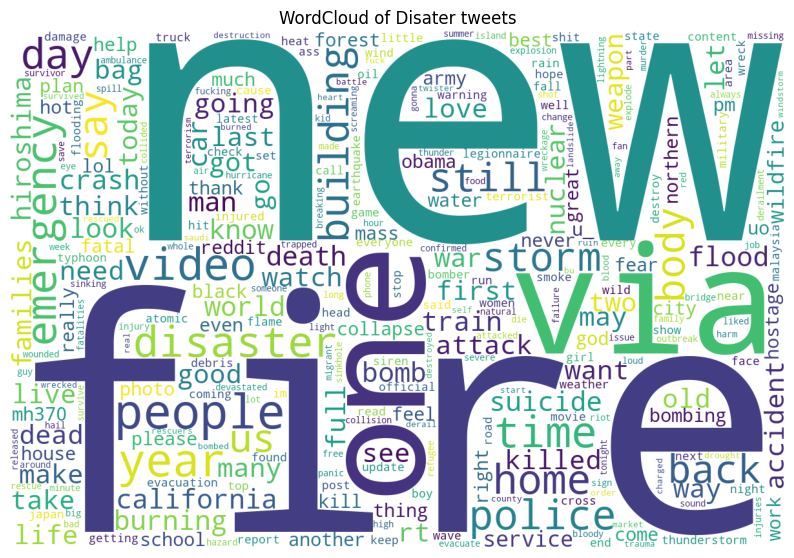

In [13]:
from wordcloud import WordCloud
plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=300, width=1200, height = 800, background_color="white",collocations=False).generate(" ".join(train_df['processed_text']))

plt.grid(None)
plt.title('WordCloud of Disater tweets')
plt.axis('off')
plt.imshow(wordcloud)

Key Observations:

- Most Frequent Words (Largest Words)

  - "new", "fire", "via", "people", "disaster", "year", "video"

  - These words suggest that many tweets talk about new incidents, fires, disasters, and media coverage.

- Common Disaster-Related Terms

  - Words like "emergency", "flood", "storm", "police", "bomb", "death", "attack", "burning", "crash", and "evacuation" indicate discussions about various catastrophic events.

- Social Media & Reporting Terms

  - Words like "via", "video", "watch", "reddit", and "news" suggest that tweets include links to disaster footage, news updates, or discussions.

- Geographical & Event-Specific Mentions

  - "California", "hiroshima", "Malaysia", and "mh370" (likely referring to the missing Malaysia Airlines flight MH370).

This implies the dataset includes discussions on historical and current disaster events.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Prepare the data
X_train = train_df['processed_text']
y_train = train_df['target']
X_test = test_df['processed_text']
y_test = test_df['targey']

# 2. Vectorize the text
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# 3. Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 4. Train a baseline model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
val_preds = model.predict(X_val)
print(classification_report(y_val, val_preds))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       874
           1       0.79      0.68      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [15]:
# Check for any remaining special chars
def check_artifacts(text):
    return bool(re.search(r'[^\w\s-]', text))

residual_issues = train_df['processed_text'].apply(check_artifacts).sum()
print(f"Texts with residual artifacts: {residual_issues}")

Texts with residual artifacts: 634
